#Predict Gene Family Using DNA Sequence

In this tutorial, we will build a classification model that is trained on the human DNA sequence and can predict a gene family based on the DNA sequence. To test the model, we will use the DNA sequence of humans, dogs, and chimpanzees and compare the accuracies.

Gene families are groups of related genes that share a common ancestor. Members of gene families may be paralogs or orthologs. Gene paralogs are genes with similar sequences from within the same species while gene orthologs are genes with similar sequences in different species.

The dataset contains Human DNA sequence, Dog DNA sequence, and Chimpanzee DNA sequence.

Adapted from AKASH KUMAR [DNA Sequencing with Machine Learning](https://www.kaggle.com/code/singhakash/dna-sequencing-with-machine-learning/notebook).

##DNA Sequence

The chemical representation of DNA is double-helix. But DNA is special. It’s a nucleotide made of four types of nitrogen bases: Adenine (A), Thymine (T), Guanine (G), and Cytosine (C). We always call them A, C, G and T.

DNA sequence is usually stored as a FASTA file. Each sequence begins with a single-line description, followed by lines of sequence data. The single-line description contains a greater-than (>) symbol in the first column, followed by the sequence name and other information. For a complete description of the FASTA file format, see http://www.ncbi.nlm.nih.gov/blast/fasta.shtml.


##Load DNA Sequence

We will use Bio.SeqIO from Biopython for parsing DNA sequence data (fasta). It provides a simple uniform interface to input and output assorted sequence file formats. 

In [1]:
# Install biopython
!pip install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 23.1 MB/s 


In [2]:
# Get sample DNA sequence
!wget "https://raw.githubusercontent.com/udel-cbcb/al_ml_workshop/main/data/example_dna.fa" -O example_dna.fa
!head example_dna.fa

--2022-06-06 18:16:05--  https://raw.githubusercontent.com/udel-cbcb/al_ml_workshop/main/data/example_dna.fa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3099 (3.0K) [text/plain]
Saving to: ‘example_dna.fa’

example_dna.fa      100%[===================>]   3.03K  --.-KB/s    in 0s      

2022-06-06 18:16:05 (37.8 MB/s) - ‘example_dna.fa’ saved [3099/3099]

>ENST00000435737.5 cds chromosome:GRCh38:3:112039620:112081269:1 gene:ENSG00000176040.13 gene_biotype:protein_coding transcript_biotype:nonsense_mediated_decay gene_symbol:TMPRSS7 description:transmembrane protease, serine 7 [Source:HGNC Symbol;Acc:HGNC:30846]
ATGTTTCGCATCACCAACATTGAGTTTCTTCCCGAATACCGACAAAAGGAGTCCAGGGAA
TTTCTTTCAGTGTCACGGACTGTGCAGCAAGTGATAAACCTGGTTTATACAACATCTGCC
TTCTCCAAATTTTATGAGCAGTC

In [3]:
from Bio import SeqIO
# Turn a sequence file into an iterator returning SeqRecords.
for sequence in SeqIO.parse('example_dna.fa', "fasta"):
    #print out sequence id
    print(sequence.id) 
    #print out sequence itself
    print(sequence.seq)
    # print out sequence length
    print(len(sequence))

ENST00000435737.5
ATGTTTCGCATCACCAACATTGAGTTTCTTCCCGAATACCGACAAAAGGAGTCCAGGGAATTTCTTTCAGTGTCACGGACTGTGCAGCAAGTGATAAACCTGGTTTATACAACATCTGCCTTCTCCAAATTTTATGAGCAGTCTGTTGTTGCAGATGTCAGCAACAACAAAGGCGGCCTCCTTGTCCACTTTTGGATTGTTTTTGTCATGCCACGTGCCAAAGGCCACATCTTCTGTGAAGACTGTGTTGCCGCCATCTTGAAGGACTCCATCCAGACAAGCATCATAAACCGGACCTCTGTGGGGAGCTTGCAGGGACTGGCTGTGGACATGGACTCTGTGGTACTAAATGAAGTCCTGGGGCTGACTCTCATTGTCTGGATTGACTGA
390
ENST00000419127.5
ATGTTTCGCATCACCAACATTGAGTTTCTTCCCGAATACCGACAAAAGGAGTCCAGGGAATTTCTTTCAGTGTCACGGACTGTGCAGCAAGTGATAAACCTGGTTTATACAACATCTGCCTTCTCCAAATTTTATGAGCAGTCTGTTGTTGCAGATGTCAGCAACAACAAAGGCGGCCTCCTTGTCCACTTTTGGATTGTTTTTGTCATGCCACGTGCCAAAGGCCACATCTTCTGTGAAGACTGTGTTGCCGCCATCTTGAAGGACTCCATCCAGACAAGCATCATAAACCGGACCTCTGTGGGGAGCTTGCAGGGACTGGCTGTGGACATGGACTCTGTGGTACTAAATGACAAAGGCTGCTCTCAGTACTTCTATGCAGAGCATCTGTCTCTCCACTACCCGCTGGAGATTTCTGCAGCCTCAGGGAGGCTGATGTGTCACTTCAAGCTGGTGGCCATAGTGGGCTACCTGATTCGTCTCTCAATCAAGTCCATCCAAATCGAAGCCGACAACTGTGTCACTGACTCCCTGACCATTTACGACTCCCTTTTGCCCATCCGGAGCAG

##Make DNA sequence data AI/ML ready

Since machine learning or deep learning models require input to be feature matrices or numerical values and currently we still have our data in character or string format. So the next step is to encode these characters into matrices.

There are 3 general approaches to encode sequence data:
* Ordinal encoding DNA Sequence
* One-hot encoding DNA Sequence
* Treat DNA sequence as a “language”, use k-mer counting

So let us implement each of them and see which gives us the perfect input features.

###Ordinal encoding DNA sequence data

In this approach, we need to encode each bases as an ordinal value. For example “ATGC” becomes [0.25, 0.5, 0.75, 1.0]. Any other base such as “N” can be a 0.

So let us create functions such as for creating a NumPy array object from a sequence string, and a label encoder with the DNA sequence alphabet “a”, “c”, “g” and “t”, but also a character for anything else, “n”.

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # create visualization
import re # Support for regular expressions (RE)

# Convert a sequence string to NumPy array
def string_to_array(seq_string):
   # make all alphabet lower case
   seq_string = seq_string.lower()
   # replace all non "a", "c", "g", "t" alphabet with "n"
   seq_string = re.sub('[^acgt]', 'n', seq_string)
   # create a NumPy array object
   seq_string = np.array(list(seq_string))
   return seq_string

# create a label encoder with 'acgtn' alphabet
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(np.array(['a','c','g','t','n']))
# LabelEncoder.fit() uses numpy.unique which will always return the data as sorted
# customize the order of labels to maintain their orders
label_encoder.classes_ = np.array(['a','c','g','t','n'])

And here is a function to encode a DNA sequence string as an ordinal vector. It returns a NumPy array with A=0.25, C=0.50, G=0.75, T=1.00, n=0.00.

In [6]:
# Encode a DNA sequence string as an ordinal vector
def ordinal_encoder(my_array):
    integer_encoded = label_encoder.transform(my_array)
    float_encoded = integer_encoded.astype(float)
    float_encoded[float_encoded == 0] = 0.25 # A
    float_encoded[float_encoded == 1] = 0.50 # C
    float_encoded[float_encoded == 2] = 0.75 # G
    float_encoded[float_encoded == 3] = 1.00 # T
    float_encoded[float_encoded == 4] = 0.00 # anything else, lets say n
    return float_encoded

#Let’s try it out a simple short sequence:
seq_test = 'TTCAGCCAGTGN'
ordinal_encoder(string_to_array(seq_test))

array([1.  , 1.  , 0.5 , 0.25, 0.75, 0.5 , 0.5 , 0.25, 0.75, 1.  , 0.75,
       0.  ])

###One-hot encoding DNA Sequence
Another approach is to use one-hot encoding to represent the DNA sequence. This is widely used in deep learning methods and lends itself well to algorithms like convolutional neural networks. In this example, “ACGTN” would become [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]. And these one-hot encoded vectors can either be concatenated or turned into 2-dimensional arrays.

In [8]:
from sklearn.preprocessing import OneHotEncoder
def one_hot_encoder(seq_string):
    # Encode target labels with value between 0 and n_classes-1.
    int_encoded = label_encoder.transform(seq_string)
    # Will return sparse matrix if set True else will return an array.
    onehot_encoder = OneHotEncoder(sparse=False, dtype=int)
    # Make it 2D array
    int_encoded = int_encoded.reshape(len(int_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(int_encoded)
    return onehot_encoded


#So let’s try it out with a simple short sequence:
seq_test = 'TTCAGCCAGTGN'
one_hot_encoder(string_to_array(seq_test))

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1]])

###Treat DNA sequence as a “language”, use k-mer counting

A hurdle that still remains is that none of these above methods results in vectors of uniform length, and that is a necessity for feeding data to a classification or regression algorithm. So with the above methods, you have to resort to things like truncating sequences or padding with “n” or “0” to get vectors of uniform length.


DNA and protein sequences can be seen as the language of life. The language encodes instructions as well as functions for the molecules that are found in all life forms. The sequence language resemblance continues with the genome as the book, subsequences (genes and gene families) are sentences and chapters, k-mers and peptides are words, and nucleotide bases and amino acids are the alphabets. Since the relationship seems so likely, it stands to reason that the natural language processing (NLP) should also implement the natural language of DNA and protein sequences.


The method we use here is manageable and easy. We first take the long biological sequence and break it down into k-mer length overlapping “words”. For example, if we use “words” of length 6 (hexamers), “TTCAGCCAGTGN” becomes: ‘TTCAGC’, ‘TCAGCC’, ‘CAGCCA’, ‘AGCCAG’, 'GCCAGT', 'CCAGTG', 'CAGTGN'. Hence our example sequence is broken down into 7 hexamer words.


In genomics, we refer to these types of manipulations as “k-mer counting”, or counting the occurrences of each possible k-mer sequence and Python natural language processing tools make it super easy.

In [9]:
def Kmers_funct(seq, size=6):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]


#So let’s try it out with a simple sequence:
mySeq = 'TTCAGCCAGTGN'
Kmers_funct(mySeq, size=6)

['ttcagc', 'tcagcc', 'cagcca', 'agccag', 'gccagt', 'ccagtg', 'cagtgn']

It returns a list of k-mer “words.” You can then join the “words” into a “sentence”, then apply your favorite natural language processing methods on the “sentences” as you normally would.

In [10]:
words = Kmers_funct(mySeq, size=6)
joined_sentence = ' '.join(words)
joined_sentence

'ttcagc tcagcc cagcca agccag gccagt ccagtg cagtgn'

You can tune both the word length and the amount of overlap. This allows you to determine how the DNA sequence information and vocabulary size will be important in your application. For example, if you use words of length 6, and there are 4 letters, you have a vocabulary of size 4096 possible words. You can then go on and create a bag-of-words model like you would in NLP.

Let’s make a couple more “sentences” to make it more interesting.

In [11]:
mySeq1 = 'TCTCACACATGTGCCAATCACTGTCACCC'
mySeq2 = 'GTGCCCAGGTTCAGTGAGTGACACAGGCAG'
sentence1 = ' '.join(Kmers_funct(mySeq1, size=6))
sentence2 = ' '.join(Kmers_funct(mySeq2, size=6))

In [12]:
#Creating the Bag of Words model:
from sklearn.feature_extraction.text import CountVectorizer
# Convert a collection of text documents to a matrix of token counts.
cv = CountVectorizer()
X = cv.fit_transform([joined_sentence, sentence1, sentence2]).toarray()
X

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1]])

##Machine Learning Use Case

### Load Human DNA data

In [13]:
!wget "https://raw.githubusercontent.com/udel-cbcb/al_ml_workshop/main/data/human.txt" -O human.txt
human_dna = pd.read_table('human.txt')
print(human_dna.shape)
human_dna.head()

--2022-06-06 18:29:05--  https://raw.githubusercontent.com/udel-cbcb/al_ml_workshop/main/data/human.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5547716 (5.3M) [text/plain]
Saving to: ‘human.txt’

human.txt           100%[===================>]   5.29M  --.-KB/s    in 0.02s   

2022-06-06 18:29:05 (294 MB/s) - ‘human.txt’ saved [5547716/5547716]

(4380, 2)


,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


Text(0.5, 1.0, 'Class distribution of Human DNA')

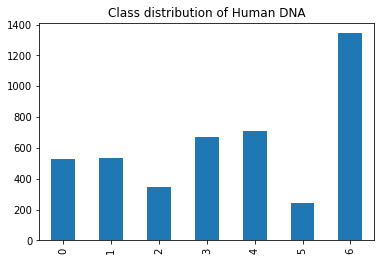

In [14]:
# Plot Class distribution of Human DNA data
human_dna['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of Human DNA")

The definition for each of the 7 classes and how many there are in the human training data are list in the table below:

```markdown
Gene family                 | Number | Class label 
----------------------------|--------|------------
G protein coupled receptors |    531 |           0 
Tyrosine kinase             |    534 |           1
Tyrosine phosphatase        |    349 |           2
Synthetase                  |    672 |           3
Synthase                    |    711 |           4
Ion channel                 |    240 |           5
Transcription factor        |   1343 |           6

```

###Load Chimpanzee DNA data

In [15]:
!wget "https://raw.githubusercontent.com/udel-cbcb/al_ml_workshop/main/data/chimpanzee.txt" -O chimpanzee.txt
chimpanzee_dna = pd.read_table('chimpanzee.txt')
print(chimpanzee_dna.shape)
chimpanzee_dna.head()

--2022-06-06 18:29:35--  https://raw.githubusercontent.com/udel-cbcb/al_ml_workshop/main/data/chimpanzee.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3258260 (3.1M) [text/plain]
Saving to: ‘chimpanzee.txt’

chimpanzee.txt      100%[===================>]   3.11M  --.-KB/s    in 0.02s   

2022-06-06 18:29:35 (191 MB/s) - ‘chimpanzee.txt’ saved [3258260/3258260]

(1682, 2)


,sequence,class
0,ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...,4
2,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
3,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
4,ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...,6


Text(0.5, 1.0, 'Class distribution of Chimpanzee DNA')

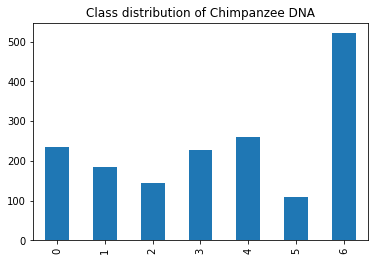

In [16]:
# Plot Class distribution of Chimpanzee DNA data
chimpanzee_dna['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of Chimpanzee DNA")

###Load Dog DNA data

In [17]:
!wget "https://raw.githubusercontent.com/udel-cbcb/al_ml_workshop/main/data/dog.txt" -O dog.txt
dog_dna = pd.read_table('dog.txt')
print(dog_dna.shape)
dog_dna.head()

--2022-06-06 18:29:50--  https://raw.githubusercontent.com/udel-cbcb/al_ml_workshop/main/data/dog.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1667375 (1.6M) [text/plain]
Saving to: ‘dog.txt’

dog.txt             100%[===================>]   1.59M  --.-KB/s    in 0.01s   

2022-06-06 18:29:50 (132 MB/s) - ‘dog.txt’ saved [1667375/1667375]

(820, 2)


,sequence,class
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0


Text(0.5, 1.0, 'Class distribution of Dog DNA')

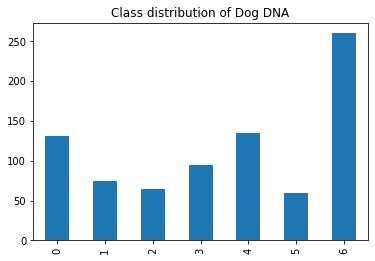

In [18]:
# Plot Class distribution of Dog DNA data
dog_dna['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of Dog DNA")

In [ ]:
human_dna

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3
...,...,...
4375,ATGGAAGATTTGGAGGAAACATTATTTGAAGAATTTGAAAACTATT...,0
4376,ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...,6
4377,ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...,6
4378,ATGGGGCACCTGGTTTGCTGTCTGTGTGGCAAGTGGGCCAGTTACC...,6


### Convert sequence of characters into k-mer words, default size = 6 (hexamers).

In [19]:
#convert our training data sequences into short overlapping k-mers of length 6. 
#Lets do that for each species of data we have using our Kmers_funct function.

human_dna['words'] = human_dna.apply(lambda x: Kmers_funct(x['sequence']), axis=1)
human_dna = human_dna.drop('sequence', axis=1)

chimpanzee_dna['words'] = chimpanzee_dna.apply(lambda x: Kmers_funct(x['sequence']), axis=1)
chimpanzee_dna = chimpanzee_dna.drop('sequence', axis=1)

dog_dna['words'] = dog_dna.apply(lambda x: Kmers_funct(x['sequence']), axis=1)
dog_dna = dog_dna.drop('sequence', axis=1)

The DNA sequence is changed to lowercase, divided into all possible k-mer words of length 6, and ready for the next step.

In [20]:
human_dna.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


We need to now convert the lists of k-mers for each gene into string sentences of words that can be used to create the Bag of Words model. We will make a target variable y to hold the class labels.

In [21]:
human_texts = list(human_dna['words'])
for item in range(len(human_texts)):
    human_texts[item] = ' '.join(human_texts[item])
#separate labels
y_human = human_dna.iloc[:, 0].values # y_human for human_dna
y_human

array([4, 4, 3, ..., 6, 6, 6])

In [22]:
chimpanzee_texts = list(chimpanzee_dna['words'])
for item in range(len(chimpanzee_texts)):
    chimpanzee_texts[item] = ' '.join(chimpanzee_texts[item])
#separate labels
y_chimpanzee = chimpanzee_dna.iloc[:, 0].values # y_chimpanzee for chimpanzee_dna
y_chimpanzee


array([4, 4, 4, ..., 6, 3, 3])

In [23]:
dog_texts = list(dog_dna['words'])
for item in range(len(dog_texts)):
    dog_texts[item] = ' '.join(dog_texts[item])
#separate labels
y_dog = dog_dna.iloc[:, 0].values  # y_dog for dog_dna
y_dog

array([4, 4, 6, 6, 0, 6, 0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 6, 0, 0, 0, 0, 0,
       6, 0, 0, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 3, 0, 6, 0, 6, 0, 6, 0,
       6, 0, 0, 3, 3, 6, 6, 6, 6, 4, 0, 0, 4, 2, 0, 0, 0, 0, 6, 0, 6, 0,
       0, 5, 5, 6, 4, 6, 0, 0, 3, 6, 3, 6, 6, 6, 6, 6, 4, 6, 4, 1, 4, 0,
       0, 0, 6, 4, 4, 6, 6, 6, 6, 6, 4, 6, 6, 3, 3, 3, 3, 0, 6, 3, 3, 6,
       4, 4, 5, 6, 6, 1, 5, 2, 2, 1, 4, 2, 6, 3, 3, 6, 6, 6, 3, 3, 6, 6,
       6, 3, 6, 6, 2, 0, 0, 6, 6, 3, 3, 3, 0, 0, 4, 6, 6, 5, 1, 1, 0, 0,
       0, 4, 0, 4, 0, 0, 3, 4, 6, 0, 6, 6, 3, 4, 0, 6, 6, 1, 2, 2, 2, 3,
       6, 2, 2, 2, 6, 0, 0, 6, 6, 0, 0, 1, 6, 5, 5, 6, 0, 6, 0, 0, 4, 0,
       0, 3, 4, 0, 0, 6, 6, 5, 5, 3, 4, 1, 0, 6, 5, 6, 6, 4, 4, 2, 2, 2,
       4, 6, 4, 4, 2, 1, 3, 6, 0, 6, 2, 3, 0, 0, 6, 0, 6, 4, 3, 1, 1, 4,
       6, 4, 4, 6, 3, 3, 2, 2, 1, 1, 3, 3, 4, 3, 0, 3, 5, 5, 5, 5, 5, 5,
       5, 2, 2, 4, 4, 6, 4, 4, 6, 6, 6, 0, 3, 3, 4, 3, 0, 0, 6, 0, 0, 6,
       6, 1, 5, 5, 0, 0, 6, 6, 1, 1, 1, 4, 2, 2, 3,

###k-mer counting

We can create the Bag of Words model using *CountVectorizer()*, which is equivalent to k-mer counting. It converts the k-mer words into uniform length numerical vectors that represent counts for every k-mer in the vocabulary

In [24]:
# Convert a collection of text documents to a matrix of token counts.
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4)) #The n-gram size of 4 is previously determined by testing
X_human = cv.fit_transform(human_texts)
X_chimpanzee = cv.transform(chimpanzee_texts)
X_dog = cv.transform(dog_texts)


In [25]:
print(X_human.shape)
print(X_chimpanzee.shape)
print(X_dog.shape)

(4380, 232414)
(1682, 232414)
(820, 232414)


So, for humans we have 4380 genes converted into uniform length feature vectors of 4-gram k-mer (length 6) counts. For chimp and dog, we have the same number of features with 1682 and 820 genes respectively.

So now that we know how to transform our DNA sequences into uniform length numerical vectors in the form of k-mer counts and ngrams, we can now go ahead and build a classification model that can predict the DNA sequence function based only on the sequence itself.

We will use the human data to train the model, holding out 20% of the human data to test the model. Then we can challenge the model’s generalizability by trying to predict sequence function in other species (the chimpanzee and dog).

Next, train/test split human dataset and build simple multinomial naive Bayes classifier.

You might want to do some parameter tuning and build a model with different ngram sizes, here I’ll go ahead with an ngram size of 4 and a model alpha of 0.1.

###Train test data split

In [26]:
# Splitting the human dataset into the training set (80%) and test set (20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_human, 
                                                    y_human, 
                                                    test_size = 0.20, 
                                                    random_state=42)

We will create a Multinomial Naive Bayes classifier, which is suitable for classification with
discrete features (e.g., word counts for text classification).

### Build prediction model

In [27]:
from sklearn.naive_bayes import MultinomialNB
#alpha : float, default=1.0
#    Additive (Laplace/Lidstone) smoothing parameter
# create a Multinomial Naive Bayes classifier model
classifier = MultinomialNB(alpha=0.1)
# fit the model
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

###Predict on the human hold out test set and see how it performes on unseen data

In [28]:
y_pred = classifier.predict(X_test)

Okay, so let's look at some model performce metrics like the confusion matrix, accuracy, precision, recall and f1 score. We are getting really good results on our unseen data, so it looks like our model did not overfit to the training data. In a real project I would go back and sample many more train test splits since we have a relatively small data set.

###Check model performance on human test DNA data

In [29]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix for predictions on human test DNA sequence\n")
#Compute a simple cross tabulation of two (or more) factors. By default
#computes a frequency table of the factors unless an array of values and an
#aggregation function are passed.
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))


Confusion matrix for predictions on human test DNA sequence

Predicted   0    1   2    3    4   5    6
Actual                                   
0          99    0   0    0    1   0    2
1           0  104   0    0    0   0    2
2           0    0  78    0    0   0    0
3           0    0   0  124    0   0    1
4           1    0   0    0  143   0    5
5           0    0   0    0    0  51    0
6           1    0   0    1    0   0  263
accuracy = 0.984 
precision = 0.984 
recall = 0.984 
f1 = 0.984


###Do prediction on Chimpanzee DNA sequence

In [30]:
y_pred_chimpanzee = classifier.predict(X_chimpanzee)

###Check model performance on Chimpanzee DNA data

In [31]:
# performance on chimpanzee genes
print("Confusion matrix for predictions on Chimpanzee test DNA sequence\n")
print(pd.crosstab(pd.Series(y_chimpanzee, name='Actual'), pd.Series(y_pred_chimpanzee, name='Predicted')))
accuracy, precision, recall, f1 = get_metrics(y_chimpanzee, y_pred_chimpanzee)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix for predictions on Chimpanzee test DNA sequence

Predicted    0    1    2    3    4    5    6
Actual                                      
0          232    0    0    0    0    0    2
1            0  184    0    0    0    0    1
2            0    0  144    0    0    0    0
3            0    0    0  227    0    0    1
4            2    0    0    0  254    0    5
5            0    0    0    0    0  109    0
6            0    0    0    0    0    0  521
accuracy = 0.993 
precision = 0.994 
recall = 0.993 
f1 = 0.993


###Do prediction on Dog DNA data

In [32]:
y_pred_dog = classifier.predict(X_dog)

###Check model performance on Dog DNA data

In [33]:
# performance on dog genes
print("Confusion matrix for predictions on Dog test DNA sequence\n")
print(pd.crosstab(pd.Series(y_dog, name='Actual'), pd.Series(y_pred_dog, name='Predicted')))
accuracy, precision, recall, f1 = get_metrics(y_dog, y_pred_dog)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix for predictions on Dog test DNA sequence

Predicted    0   1   2   3    4   5    6
Actual                                  
0          127   0   0   0    0   0    4
1            0  63   0   0    1   0   11
2            0   0  49   0    1   0   14
3            1   0   0  81    2   0   11
4            4   0   0   1  126   0    4
5            4   0   0   0    1  53    2
6            0   0   0   0    0   0  260
accuracy = 0.926 
precision = 0.934 
recall = 0.926 
f1 = 0.925


The model seems to produce good results on human data. It also does on Chimpanzee which is because the Chimpanzee and humans share the same genetic hierarchy. The performance of the dog is not quite as good which is because the dog is more diverging from humans than the chimpanzee.